In [1]:
import pandas as pd
import numpy as np

df_unesco = pd.read_csv("unesco.csv")
df_unesco_train = pd.read_csv("unesco_train.csv")
df_unesco.set_index(["Country", "Year"], inplace=True)
df_unesco_train.set_index(["Country", "Year"], inplace=True)

The first step is to find the type of machine learning regressor that works the best on our data.  I test this by comparing RMSE's of different learners, including all the features.

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

my_cols = ['fertilityRate', 'lifeExpectancy', 'popGrowth',
           'ruralPopPct', 'mortalityRate', 'gdpGrowthPct', 
           'gdpUS', 'gdpPerCapita ppp', 'gdp pppInternational',
           'gni', 'gniPerCapita', 'happinessScore']

Xtrain = df_unesco_train[my_cols]
Xtrain = Xtrain.dropna()
ytrain = Xtrain["happinessScore"]
Xtrain.drop("happinessScore", axis=1, inplace=True)

def tryModel(model):

  pipeline = make_pipeline(
      StandardScaler(),
      model
    )

  cv_errs = -cross_val_score(pipeline, X=Xtrain, y=ytrain,
                             scoring="neg_mean_squared_error", cv=10)
  
  return pipeline, np.sqrt(cv_errs.mean())

lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt")
params = {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
gr = GradientBoostingRegressor(**params) 

model_dict = {'lr': lr, 'knn': knn, 'dt': dt, 'rf': rf, 'gr': gr}

errs = pd.Series()
for k, v in model_dict.items():
  errs[k] = tryModel(v)[1]
errs

lr     0.670229
knn    0.665158
dt     0.763525
rf     0.586655
gr     0.618608
dtype: float64

With the lowest estimated test RMSE around .6, random forrest is the best machine learning model out of those I tested.  The RMSE of .6 can be interpreted as follows: given a country and a year, a prediction for the happiness score will be off by .6 on average.

The cells below is where I perform feature selection, choosing only the features that help to predict happines scores.  

11
11


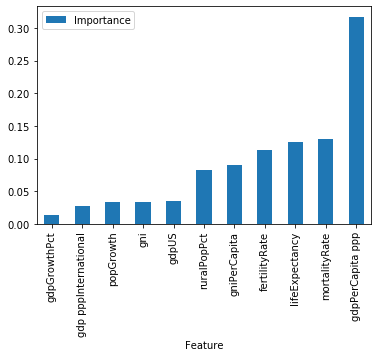

In [56]:
rf = RandomForestRegressor(max_features="sqrt")
# no need to scale for random forest

rf.fit(Xtrain, ytrain)
importances = rf.feature_importances_
print(len(importances))
print(len(Xtrain.columns))
importances = pd.DataFrame({'Feature':Xtrain.columns,'Importance':importances})
importances.sort_values(by='Importance').set_index('Feature').plot.bar()

These feature importance scores match my intuition.  It makes sense to me that GDP Per Capita PPP (Purchasing Power Parity) is the most important feature because it describes individual relative wealth.  It also makes sense that features like mortality rate, life expectancy, and fertility rate are more importnact than features like gdp and gdp growth.

In the cell below, I'm going to compare and contrast the model with all of the features to one with only the most important features.

In [72]:
errs = pd.Series()

all_cols = ['fertilityRate', 'lifeExpectancy', 'popGrowth',
           'ruralPopPct', 'mortalityRate', 'gdpGrowthPct', 
           'gdpUS', 'gdpPerCapita ppp', 'gdp pppInternational',
           'gni', 'gniPerCapita', 'happinessScore']

Xtrain_all = df_unesco_train[all_cols]
Xtrain_all = Xtrain_all.dropna()
ytrain_all = Xtrain_all["happinessScore"]
Xtrain_all.drop("happinessScore", axis=1, inplace=True)

best_cols = ['fertilityRate', 'lifeExpectancy', 'ruralPopPct', 'mortalityRate', 
             'gdpPerCapita ppp', 'gniPerCapita', 'happinessScore']

Xtrain_best = df_unesco_train[best_cols]
Xtrain_best = Xtrain_best.dropna()
ytrain_best = Xtrain_best["happinessScore"]
Xtrain_best.drop("happinessScore", axis=1, inplace=True)

def tryModel(Xtrain, ytrain):
  cv_errs = -cross_val_score(rf, X=Xtrain, y=ytrain,
                             scoring="neg_mean_squared_error", cv=10)
  
  return np.sqrt(cv_errs.mean())

iterations = 10
all_rmse = 0
best_rmse = 0

for i in range(iterations):
    all_rmse += tryModel(Xtrain_all, ytrain_all)
    best_rmse += tryModel(Xtrain_best, ytrain_best)
   
errs['All features'] = all_rmse/iterations
errs['Best features'] = best_rmse/iterations
errs

All features     0.605296
Best features    0.615033
dtype: float64

In [63]:
# making graphs for a country over time, color coding by predicted vs known happiness data

#This method takes in country name and returns series of happiness score guesses from 1970 to 2017
# can be used to plot happiness score estimates vs year
Xtrain = df_combined[list(my_cols)]
Xtrain = Xtrain.dropna()
ytrain = Xtrain["happinessScore"]
Xtrain.drop("happinessScore", axis=1, inplace=True)

def predict_country(country):
    cols = my_cols
    cols.remove("happinessScore")
    Xtest = df_combined[list(cols)]
   
    df_country = df_unesco.loc[df_unesco['Country'] == country]
    df_country = df_country[list(my_cols)]
    df_country = df_country.reset_index()
    df_country = df_country.drop(['index'], axis=1)
    
#     df_new = df_unesco['Year'].unique()
#     print(len(df_new))
    y_pred = rf.fit(Xtrain, ytrain).predict(df_country)
    return pd.Series(y_pred)
    
    

happiness_predictions = predict_country("Iraq")


NameError: name 'df_combined' is not defined

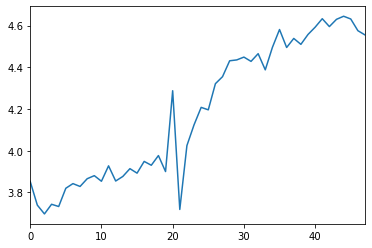

In [139]:
happiness_predictions.plot.line()


Predicted graph starting at 1970 to 2017 for Iraq
